# Hard sphere dimer LSMC simulations

## Preliminaries

Import the Python packages we'll need, and initialise two simulation boxes with the correct number of chains and beads per chain for the files we'll read. Note that because the model code is written in Fortran internally, replicas, chains and bead indices are 1-based not zero-based. 

In [1]:
import numpy as np  # Numpy
import math as m    # Maths

import hs_alkane as mdl   # Fortran library we'll used to model the alkane chain

In [2]:
Nbeads  = 2    # Dimers
Nchains = 288  # 288 chains in input00[0-1].xmol

# The configurations we'll read have a bond length of L=0.5
mdl.alkane_set_bondlength(0.5)

# Initialise the simulation box and alkane module ready to hold chains
mdl.box_set_num_boxes(2)
mdl.box_initialise()             
mdl.alkane_set_nbeads(Nbeads)    
mdl.alkane_set_nchains(Nchains)  
mdl.alkane_initialise() 

# By default we have periodic boundary conditions, and the example below benefits from using link cells
# to speed up computation. These can be disabled (and will be automatically if the system is too small for them)
# or we can specify that we want to use a Verlet neighbour list instead. If using the neighbour list then we 
# need to make sure if is updated appropriately after moving beads around, but for a mostly static crystal that
# isn't necessary.
#mdl.box_set_bypass_link_cells(1)
#mdl.box_set_use_verlet_list(1)


|=======================================|
| Initialised   1 simulation box(es)    |
| Cell vectors have been reset.         |
|=======================================|


|=======================================|
| Initialised   2 simulation box(es)    |
| Cell vectors have been reset.         |
|=======================================|


|=======================================|
| Initialised   288 chains              |
| Beads per chain :     2               |
| Bead positions have been reset.       |
|=======================================|



## Read initial configurations from xmol files in current working directory

This needs to contain the correct number of beads to match Nchains and Nbeads as defined above. The second line in the xmol file should contain the three cell vectors as illustrated below. Positions 1-2 are for the first dimer, position 3-4 the second, and so on.

In [3]:
!head chain.xmol.0001

576
    4.16272748269267 0.0 0.0 0.0 5.404029570226723 0.0 0.0 0.0 16.15999248657107
C   -2.04990920 -2.69610582 -8.05304547
C   -2.04942884 -2.81173852 -7.56660036
C   -1.56765690 -1.78948556 -8.05717295
C   -1.59598892 -1.89605599 -7.56948448
C   -2.07697161 -1.61412707 -6.72414779
C   -2.07291455 -1.70395491 -6.23229974
C   -1.52950397 -2.58058694 -6.73067302
C   -1.60381490 -2.62098790 -6.23787930


In [4]:
# Read from chain.xmol
mdl.io_read_xmol()               # Read from chain.xmol

 hmatrix   4.1627274826926701        0.0000000000000000        0.0000000000000000        0.0000000000000000        5.4040295702267231        0.0000000000000000        0.0000000000000000        0.0000000000000000        16.159992486571070        0.0000000000000000        0.0000000000000000        0.0000000000000000        0.0000000000000000        0.0000000000000000        0.0000000000000000        0.0000000000000000        0.0000000000000000        0.0000000000000000     
 dot prods   4.1627274826926701        5.4040295702267231        16.159992486571070      link cell length   1.5000000000000000     
 hmatrix   4.1627274826926701        0.0000000000000000        0.0000000000000000        0.0000000000000000        5.4040295702267231        0.0000000000000000        0.0000000000000000        0.0000000000000000        16.159992486571070        4.1607259631802229        0.0000000000000000        0.0000000000000000        0.0000000000000000        5.4046861074273727        0.00000000000000

system too small for link cells of this length    2    3   10
system too small for link cells of this length    2    3   10


In [5]:
# Construct neighbour lists if we can (too small for link cells in this example)
for ibox in range(2) : mdl.alkane_construct_neighbour_list(ibox+1) 

!=======================================!
! This compiler stores .true. as :     1!
!=======================================!
Neighbour list constructed in :        0.004000 seconds
Neighbour list constructed in :        0.004000 seconds


### Sanity check initial configuration

Functions are provided to check that the configuration obeys the model constraints on bond length. We also check that no beads overlap, other than those which are allowed to in the model, e.g. the two beads within a dimer.

In [6]:
# Loop over chains and sanity check configuration
for ibox in range(2):
    for ichain in range(0, Nchains):
    
        # Checks if internal geometry of chain (bonds/angles) are consistent with the model
        geom_flag = mdl.alkane_check_chain_geometry(ichain+1, ibox+1)
        if geom_flag != 0:
            print("Incorrect geometry for chain ",ichain," in box ",ibox+1)
       
    
    # Checks if beads on any two chains overlap
    overlap_flag = mdl.alkane_check_chain_overlap(ibox+1)
    if overlap_flag != 0:
        print("Overlaps between chains in configuration")
    else:
        print("No overlaps between chains found in configuration")  

No overlaps between chains found in configuration
No overlaps between chains found in configuration


## Monte Carlo loop

We will use translation and rotation moves only.

In [ ]:
# For progress bar
from ipywidgets import IntProgress
from IPython.display import display

# Move types
move_types = ['box', 'translate', 'rotate']
ivol = 0; itrans = 1; irot = 2; 
moves_attempted = np.zeros(3, dtype=int)
moves_accepted  = np.zeros(3, dtype=int)

# Set move sizes
mdl.alkane_set_dr_max(0.012)    # Max translation move
mdl.alkane_set_dt_max(0.10)    # Max rotation move (radians)

# Active and passive lattice
lsl = (2, 1)
ls = 1             # Active lattice
lsn = lsl[ls-1]    # Passive lattice

# Initialise counters
Nsweeps = 1000
isweep = 0

# Initialise LSMC overlap parameter
# This is overlaps(1) - overlaps(2)
ls_sign = (1, -1)
ls_mu = 0

# Create progress bar
f = IntProgress(min=0, max=Nsweeps) 
display(f) # display the bar

# How often to sample quantities
sample_interval = 10
samples = list()

# If we can't use link cells try using Verlet neighbour list
mdl.box_set_use_verlet_list(1) 
mdl.alkane_construct_neighbour_list(1)
mdl.alkane_construct_neighbour_list(2)

#Initialise timer
t1 = mdl.timer_init()

# Loop over the number of MC sweeps to perform
while isweep < Nsweeps:
    
    # One "sweep" is usually interpretted as one attempt to change each degree of freedom on average once.
    # here we have 3 translation + 2 rotation degrees of freedom per chain, plus 6 degrees
    # of freedom for the simulation cell (ignoring rotations of the box).
    
    # A chain translation move changes 3 degrees of freedom
    # A chain rotation move changes 2 degrees of freedom
    
    # Hence if we attempt each move type with a probability proportional to the number of degrees
    # of freedom it changes, we need to do 2*Nchains+6 moves to get one "sweep". Sampling in this
    # ratio isn't necessarily optimal, but it's a good starting point.
    
    # Calculate cumulative move ratios used to decide move type
    total_deg = 5*Nchains #+6

    #box_move_prob   = 6.0/total_deg
    trans_move_prob = 3.0*Nchains/total_deg # box_move_prob   
    rot_move_prob   = trans_move_prob + 2.0*Nchains/total_deg

    # Loop over move attempts at the current sweep
    imove = 0
    while imove < total_deg:

        #==========================#
        # Make a random trial move #
        #==========================#
        
        # Pick a random chain numbered from 0 to Nchains
        ichain = np.random.randint(0, high=Nchains)

        # Backup old chain positions. Note that whenever we call a routine inside the
        # hs_alkane library we need to add one to the bead/chain index to account for
        # Fortran indexing. 
        current_active_chain = mdl.alkane_get_chain(ichain+1, ls)
        backup_active_chain = current_active_chain.copy() # Note copy, not equivalence

        current_passive_chain = mdl.alkane_get_chain(ichain+1, lsn)
        backup_passive_chain = current_passive_chain.copy() # Note copy, not equivalence

        # Overlap count before move in passive lattice
        n_overlaps_passive_before = mdl.alkane_chain_count_overlaps(ichain+1, lsn)
        #print("Chain ", ichain, " has ", n_overlaps_passive_before, " overlaps in passive lattice before move.")

        # Pick a move type at random and call the appropriate function to make that 
        # trial move and return the corresponding ratio of Boltzmann factors.
        xi = np.random.random()
        #if xi < box_move_prob:
        #    # Attempt a volume move
        #    itype = ivol
        #    boltz = mdl.alkane_box_resize(pressure, ibox, 0) # 0 here indicates not a box reset
        if xi < trans_move_prob:

            # Attempt a translation move
            itype = itrans
            boltz, move = mdl.alkane_translate_chain(ichain+1, ls)

            # Make the same move in the passive lattice 
            # NOTE: if doing NPT this should be the same move in fractional/scaled coordinates
            for ibead in range(Nbeads):
                current_passive_chain[ibead] += move

        elif xi < rot_move_prob:

            # Attempt a rotation move
            itype = irot
            boltz, quat = mdl.alkane_rotate_chain(ichain+1, ls, 0) # Rotate type 0 (not about a bond)

            # Make the same rotation in the passive lattice
            for ibead in range(Nbeads):
                rbead = current_passive_chain[ibead] - current_passive_chain[0]
                rbead_rot = mdl.quat_conjugate_q_with_v(quat, rbead)
                current_passive_chain[ibead] = rbead_rot + current_passive_chain[0]

        
        # Increment attempted move counter
        moves_attempted[itype] += 1
        
        #====================#
        # Accept/reject move #
        #====================#
        
        # Reject according to Metropolis criterion
        if (np.random.random() < boltz):
            
            # Move accepted
            moves_accepted[itype] += 1
            
            # Update linked-list for new positions if not volume move. This isn't strictly
            # necessary for a perfect solid where all beads will remain in (or very near) their initial
            # link cell, but would be absolutely necessary for a fluid.
            #if (itype!=ivol):
            #    for ibead in range(Nbeads):
            #        mdl.alkane_update_linked_lists(ibead+1, ichain+1, ibox, backup_active_chain[ibead], current_active_chain[ibead])
            #        mdl.alkane_update_linked_lists(ibead+1, ichain+1, ibox, backup_passive_chain[ibead], current_passive_chain[ibead])

            # Update overlap count in passive lattice and LSMC overlap parameter
            n_overlaps_passive_after = mdl.alkane_chain_count_overlaps(ichain+1, lsn)
            #print("Chain ", ichain, " has ", n_overlaps_passive_after, " overlaps in passive lattice after move.")

            delta_overlaps = n_overlaps_passive_after - n_overlaps_passive_before
            ls_mu = ls_mu + ls_sign[lsn-1]*delta_overlaps

        else:
            
            # Reject move
            if (itype!=ivol):
                # Restore old chain if single chain move
                for ibead in range(Nbeads):
                    current_active_chain[ibead] = backup_active_chain[ibead]
                    current_passive_chain[ibead] = backup_passive_chain[ibead]

            #else:
                # Reset the box change - special fucntion for this.
            #    dumboltz = mdl.alkane_box_resize(pressure, ibox, 1) # 1 here indicates reset to previous box

        imove += 1
        
        
    # Sample 
    if isweep%sample_interval == 0:
        samples.append(ls_mu)
    
    # Increment sweep counter and progress bar
    isweep += 1
    f.value += 1
    
    
# Timing
print("Completed ",Nsweeps," sweeps in ",mdl.timer_elapsed_time()," seconds.")
    
# Report statistics
for itype in (1,2):
    percent = 100.0 * moves_accepted[itype]/moves_attempted[itype]
    print("Accepted ",percent," % of ", moves_attempted[itype], move_types[itype]," moves")

print("Current LSMC overlap parameter: ", ls_mu)

IntProgress(value=0, max=1000)

Neighbour list constructed in :        0.004000 seconds

| Timer initialised |

Completed  1000  sweeps in  44.3440000000046  seconds.
Accepted  49.162353550631124  % of  864804 translate  moves
Accepted  52.13596756583843  % of  575196 rotate  moves
Current LSMC overlap parameter:  -594


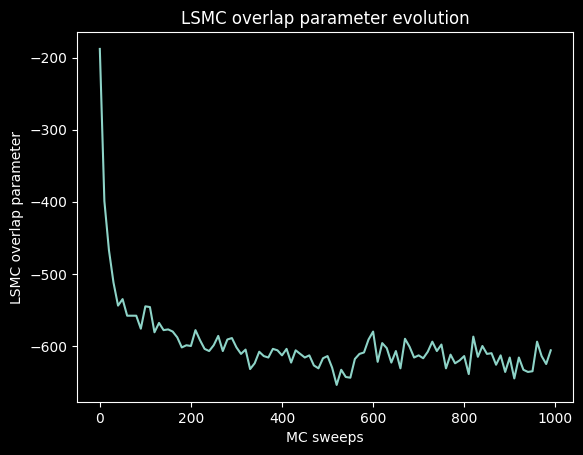

In [8]:
# Plot LSMC overlap parameter evolution
import matplotlib.pyplot as plt # For plotting

plt.plot(np.arange(0, len(samples))*sample_interval, samples)
plt.xlabel('MC sweeps')
plt.ylabel('LSMC overlap parameter')
plt.title('LSMC overlap parameter evolution')
plt.show()  